### import

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pytimekr import pytimekr

In [5]:
from utils import data_split

## 가격과 공급사이의 관계
### 1) 당일 공급과 가격 사이의 관계
### 2) 전 7일 공급의 평균값과 가격사이의 관계

In [6]:
unique_code = ['BC_C_J', 'TG_B_J', 'CR_B_J', 'RD_E_S', 'BC_A_J', 'CB_F_J', 'RD_D_J', 'TG_A_S', 'BC_E_S', 'CR_D_J', 'BC_A_S', 'BC_B_S', 'TG_E_J', 
               'CR_E_S', 'RD_F_J', 'BC_E_J', 'TG_A_J', 'CR_C_J', 'CR_D_S', 'TG_C_J', 'CB_A_S', 'TG_D_J', 'CR_E_J', 'RD_C_S', 'BC_C_S', 'CB_E_J', 
                'RD_E_J', 'BC_D_J', 'CR_A_J', 'TG_E_S', 'TG_C_S', 'TG_D_S', 'RD_A_S', 'RD_A_J', 'RD_D_S', 'TG_B_S', 'CB_D_J', 'CB_A_J', 'BC_B_J']

### data_list[data_code] : 원본데이터
### data_list[adj_code] : 선형보간된 데이터

In [7]:
data = pd.read_csv('data/train.csv')
data_list = data_split(data)

In [8]:
data = pd.read_csv('data/train.csv')


data['year'] = data['timestamp'].str.split('-').str[0]
data['month'] = data['timestamp'].str.split('-').str[1]
data['day'] = data['timestamp'].str.split('-').str[2]
data['weekday'] = pd.to_datetime(data['timestamp']).dt.weekday


data['timestamp'] = pd.to_datetime(data['timestamp'])

## 
data['is_weekend'] = 0
data['is_weekend'][data['weekday']==5] = 1
data['is_weekend'][data['weekday']==6] = 1



holidays_2019 = pytimekr.holidays(year = 2019)
holidays_2020 = pytimekr.holidays(year = 2020)
holidays_2021 = pytimekr.holidays(year = 2021)
holidays_2022 = pytimekr.holidays(year = 2022)
holidays_2023 = pytimekr.holidays(year = 2023)

all_holidays = holidays_2019 + holidays_2020 + holidays_2021 + holidays_2022 + holidays_2023

# 공휴일 여부 변수 추가
data['holiday'] = (data['timestamp'].isin(all_holidays)).astype(int)


# Initialize an empty dictionary to store filtered DataFrames
filtered_data = {}

# Define the list of items, corporations, and locations
items = ['TG', 'BC', 'CR', 'RD', 'CB']
corporations = ['A', 'B', 'C', 'D', 'E', 'F']
locations = ['J', 'S']

# Nested loops to filter the DataFrame for each combination
for item in items:
    for corporation in corporations:
        for location in locations:
            filtered_data_key = f"{item}_{corporation}_{location}"
            filtered_data[filtered_data_key] = data[(data['item'] == item) & (data['corporation'] == corporation) & (data['location'] == location)].drop(columns=['ID', 'item', 'corporation', 'location'], axis=1)


for dataset_code in unique_code:

    # na를 선형보간
    data_list[f"adj_{dataset_code}"] = filtered_data[dataset_code]
    data_list[f"adj_{dataset_code}"]['price(원/kg)'][(data_list[f"adj_{dataset_code}"]['weekday'] != 6) & (data_list[f"adj_{dataset_code}"]['holiday'] != 1) & (data_list[f"adj_{dataset_code}"]['price(원/kg)']==0)] = pd.NA
    data_list[f"adj_{dataset_code}"]['price(원/kg)'] = data_list[f"adj_{dataset_code}"][['price(원/kg)']].interpolate(method='linear')
    data_list[f"adj_{dataset_code}"]['price(원/kg)'][(data_list[f"adj_{dataset_code}"]['weekday'] != 6) & (data_list[f"adj_{dataset_code}"]['holiday'] != 1) & (data_list[f"adj_{dataset_code}"]['price(원/kg)']==0)] = pd.NA
    data_list[f"adj_{dataset_code}"]['price(원/kg)'] = data_list[f"adj_{dataset_code}"]['price(원/kg)'].replace(0, np.nan).fillna(method='ffill').fillna(0)
    # 공휴일, 일요일은 다시 0으로
    data_list[f"adj_{dataset_code}"]['price(원/kg)'][(data_list[f"adj_{dataset_code}"]['weekday'] == 6) | (data_list[f"adj_{dataset_code}"]['holiday'] == 1)] = 0

    # na를 선형보간
    data_list[f"adj_{dataset_code}"]['supply(kg)'][(data_list[f"adj_{dataset_code}"]['weekday'] != 6) & (data_list[f"adj_{dataset_code}"]['holiday'] != 1) & (data_list[f"adj_{dataset_code}"]['supply(kg)']==0)] = pd.NA
    data_list[f"adj_{dataset_code}"]['supply(kg)'] = data_list[f"adj_{dataset_code}"][['supply(kg)']].interpolate(method='linear')
    data_list[f"adj_{dataset_code}"]['supply(kg)'][(data_list[f"adj_{dataset_code}"]['weekday'] != 6) & (data_list[f"adj_{dataset_code}"]['holiday'] != 1) & (data_list[f"adj_{dataset_code}"]['supply(kg)']==0)] = pd.NA
    data_list[f"adj_{dataset_code}"]['supply(kg)'] = data_list[f"adj_{dataset_code}"]['supply(kg)'].replace(0, np.nan).fillna(method='ffill').fillna(0)
    # 공휴일, 일요일은 다시 0으로
    data_list[f"adj_{dataset_code}"]['supply(kg)'][(data_list[f"adj_{dataset_code}"]['weekday'] == 6) | (data_list[f"adj_{dataset_code}"]['holiday'] == 1)] = 0


### 1) 당일 공급과 가격 사이의 관계

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def price_supply_scatter(dataset_code, month, p):
    if month == True:
        df_tem = data_list[f'data_{dataset_code}']
        df_tem['timestamp'] = pd.to_datetime(df_tem['timestamp'])
        mask = (df_tem['timestamp'].dt.month == 2) | (df_tem['timestamp'].dt.month == 3)
        df = df_tem[mask]
    else:
        df = data_list[f'data_{dataset_code}']
        

    # 'timestamp', 'item', 'corporation', 'location' 등의 문자열이 포함된 열을 제거
    numeric_df = df[['supply(kg)', 'price(원/kg)']]

    # 0인 데이터 제거
    numeric_df = numeric_df[numeric_df['price(원/kg)'] != 0]
    
    # 각 변수의 하위 5%와 상위 5%를 제거
    lower_bound = numeric_df.quantile(0.05)
    upper_bound = numeric_df.quantile(0.95)

    df_filtered = numeric_df[
        (numeric_df['supply(kg)'] >= lower_bound['supply(kg)']) & (numeric_df['supply(kg)'] <= upper_bound['supply(kg)']) &
        (numeric_df['price(원/kg)'] >= lower_bound['price(원/kg)']) & (numeric_df['price(원/kg)'] <= upper_bound['price(원/kg)'])
    ]
    
    # 데이터 스케일링
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df_filtered[['supply(kg)', 'price(원/kg)']])
    df_scaled = pd.DataFrame(scaled_data, columns=['scaled_supply', 'scaled_price'])

    # 선형 회귀
    X_linear = df_scaled[['scaled_supply']]
    y_linear = df_scaled['scaled_price']
    model_linear = LinearRegression()
    model_linear.fit(X_linear, y_linear)

    # 다항 회귀
    degree = p  # 다항식의 차수
    X_poly = df_scaled[['scaled_supply']]
    y_poly = df_scaled['scaled_price']

    model_poly = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model_poly.fit(X_poly, y_poly)

    # 다항 회귀 및 선형 회귀 결과 그리기
    X_fit = np.linspace(df_scaled['scaled_supply'].min(), df_scaled['scaled_supply'].max(), 100)[:, np.newaxis]
    y_fit_poly = model_poly.predict(X_fit)
    y_fit_linear = model_linear.predict(X_fit)

    plt.figure(figsize=(8, 6))
    plt.scatter(df_scaled['scaled_supply'], df_scaled['scaled_price'], alpha=0.5, label='Scatter Plot')
    plt.plot(X_fit, y_fit_poly, color='red', linewidth=2, label=f'Polynomial Regression (Degree {degree})')
    plt.plot(X_fit, y_fit_linear, color='green', linewidth=2, label='Linear Regression')
    plt.title('Scatter Plot with Regression Lines (Outliers and Zero Price Removed)')
    plt.xlabel('Scaled Supply(kg)')
    plt.ylabel('Scaled Price(원/kg)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 데이터 및  결측치 개수 출력
    print(f"전체 데이터 수: {len(df)}")
    print(f"0 개수: {sum(numeric_df['price(원/kg)'] != 0)}")    

    # 두 변수의 상관관계 출력
    correlation = df_filtered['supply(kg)'].corr(df_filtered['price(원/kg)'])
    print(f'Correlation between Supply(kg) and Price(원/kg): {correlation}')
    

### 데이터셋코드, 특정달만 볼 것인지 여부, 시작달 끝달 , polynomial차수

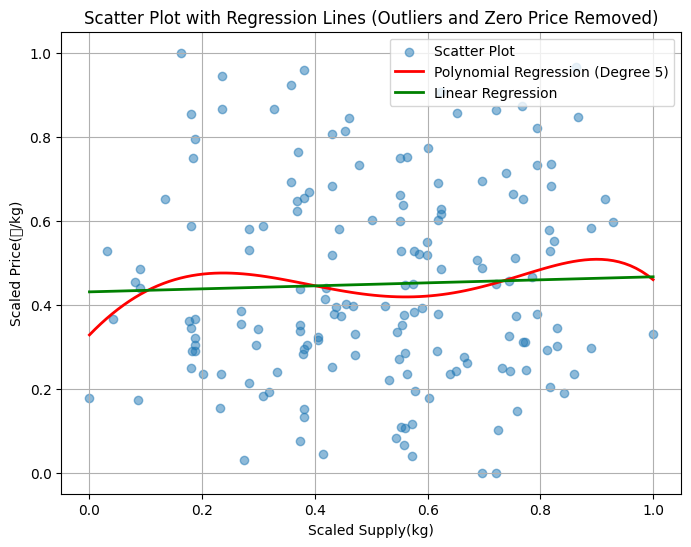

전체 데이터 수: 268
0 개수: 206
Correlation between Supply(kg) and Price(원/kg): 0.034173400814642874


In [10]:
price_supply_scatter('RD_A_S', month = True,  p = 5)

### 2) 지난 window_size 기간동안의 공급의 평균과 그 다음날 가격 사이의 관계

In [11]:
def price_ma_supply_scatter(dataset, month, p, window_size):
    if month == True:
        df_tem = dataset
        df_tem['timestamp'] = pd.to_datetime(df_tem['timestamp'])
        mask = (df_tem['timestamp'].dt.month == 2) | (df_tem['timestamp'].dt.month == 3)
        df = df_tem[mask]
    else:
        df = dataset

    # 필요한 숫자형 변수만 선택
    numeric_df = df[['supply(kg)', 'price(원/kg)']]

    # 가격이 0이 아닌 데이터만 선택
    numeric_df = numeric_df[numeric_df['price(원/kg)'] != 0]

    # 각 변수의 하위 5%와 상위 5%를 제거
    lower_bound = numeric_df.quantile(0.05)
    upper_bound = numeric_df.quantile(0.95)

    df_filtered = numeric_df[
        (numeric_df['supply(kg)'] >= lower_bound['supply(kg)']) & (numeric_df['supply(kg)'] <= upper_bound['supply(kg)']) &
        (numeric_df['price(원/kg)'] >= lower_bound['price(원/kg)']) & (numeric_df['price(원/kg)'] <= upper_bound['price(원/kg)'])
    ]

    df_filtered = df_filtered.reset_index(drop=True)

    # 7일 간격으로 데이터 그룹화
    def time_slide_df(df, window_size, forcast_size, target):
        df_ = df.copy()
        data_list = []
        dap_list = []
        date_list = []
        for idx in range(0, df_.shape[0] - window_size - forcast_size + 1):
            x = df_.loc[idx:idx+window_size-1, target].values.reshape(window_size, len(target))
            y = df_.loc[idx+window_size:idx+window_size+forcast_size-1, target].values
            data_list.append(x)
            dap_list.append(y)
        return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32')

    x, y = time_slide_df(df_filtered, window_size, 1, target=['supply(kg)', 'price(원/kg)'])

    supply_ma = np.mean(x[:, :, 0], axis=1).reshape(-1, 1)  # Reshape to 2D array
    price_target = y[:, :, 1].reshape(-1, 1)  # Reshape to 2D array

    result_df = pd.DataFrame({
        'supply_ma': supply_ma.flatten(),  # Flatten to 1D array
        'price_target': price_target.flatten()  # Flatten to 1D array
    })

    # 데이터 스케일링
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(result_df)
    result_df_scaled = pd.DataFrame(scaled_data, columns=['scaled_supply', 'scaled_price'])

    # Scatter Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(result_df_scaled['scaled_supply'], result_df_scaled['scaled_price'], alpha=0.5, label='Scatter Plot')

    # Linear Regression
    X_linear = result_df_scaled[['scaled_supply']]
    y_linear = result_df_scaled['scaled_price']
    model_linear = LinearRegression()
    model_linear.fit(X_linear, y_linear)
    plt.plot(X_linear, model_linear.predict(X_linear), color='green', linewidth=2, label='Linear Regression')

    # Polynomial Regression
    degree = p
    X_poly = result_df_scaled[['scaled_supply']]
    y_poly = result_df_scaled['scaled_price']
    model_poly = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model_poly.fit(X_poly, y_poly)
    X_fit = np.linspace(X_poly.min().values[0], X_poly.max().values[0], 100)[:, np.newaxis]  # Extracting the value from the DataFrame
    y_fit_poly = model_poly.predict(X_fit)
    plt.plot(X_fit, y_fit_poly, color='red', linewidth=2, label=f'Polynomial Regression (Degree {degree})')

    plt.title('Scatter Plot with Regression Lines')
    plt.xlabel('Scaled 7 Days Avg Supply')
    plt.ylabel('Scaled Next Day Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 두 변수의 상관관계 출력
    correlation = result_df_scaled['scaled_supply'].corr(result_df_scaled['scaled_price'])
    print(f'Correlation between ma Supply and Price(원/kg): {correlation}')

### 시각화

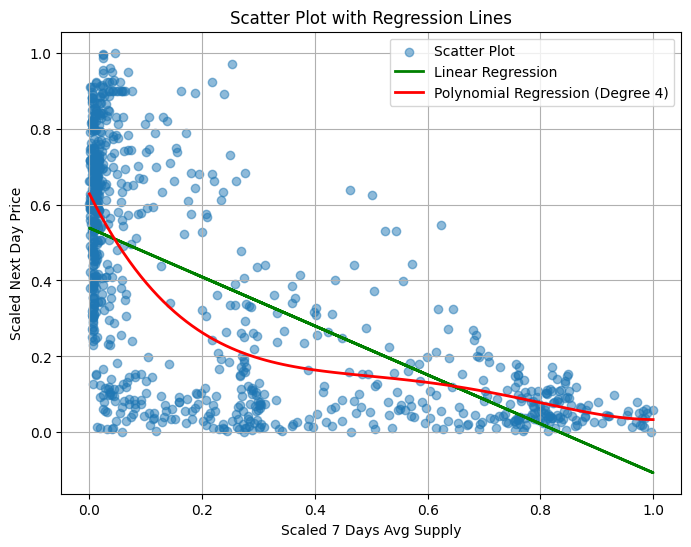

Correlation between ma Supply and Price(원/kg): -0.6519781772419806


In [12]:
price_ma_supply_scatter(data_list['data_TG_D_J'], month = False, p = 4, window_size = 30)

### 3) 지난 window_size 가격의 평균과 다음날 가격 사이의 관계

In [13]:
def price_ma_price_scatter(dataset_code, month, p, window_size):
    if month == True:
        df_tem = data_list[f'data_{dataset_code}']
        df_tem['timestamp'] = pd.to_datetime(df_tem['timestamp'])
        mask = (df_tem['timestamp'].dt.month == 2) | (df_tem['timestamp'].dt.month == 3)
        df = df_tem[mask]
    else:
        df = data_list[f'data_{dataset_code}']

    # 필요한 숫자형 변수만 선택
    numeric_df = df[['supply(kg)', 'price(원/kg)']]

    # 가격이 0이 아닌 데이터만 선택
    numeric_df = numeric_df[numeric_df['price(원/kg)'] != 0]

    # 각 변수의 하위 5%와 상위 5%를 제거
    lower_bound = numeric_df.quantile(0.05)
    upper_bound = numeric_df.quantile(0.95)

    df_filtered = numeric_df[
        (numeric_df['supply(kg)'] >= lower_bound['supply(kg)']) & (numeric_df['supply(kg)'] <= upper_bound['supply(kg)']) &
        (numeric_df['price(원/kg)'] >= lower_bound['price(원/kg)']) & (numeric_df['price(원/kg)'] <= upper_bound['price(원/kg)'])
    ]

    df_filtered = df_filtered.reset_index(drop=True)

    # 7일 간격으로 데이터 그룹화
    def time_slide_df(df, window_size, forcast_size, target):
        df_ = df.copy()
        data_list = []
        dap_list = []
        date_list = []
        for idx in range(0, df_.shape[0] - window_size - forcast_size + 1):
            x = df_.loc[idx:idx+window_size-1, target].values.reshape(window_size, len(target))
            y = df_.loc[idx+window_size:idx+window_size+forcast_size-1, target].values
            data_list.append(x)
            dap_list.append(y)
        return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32')

    x, y = time_slide_df(df_filtered, window_size, 1, target=['supply(kg)', 'price(원/kg)'])

    supply_ma = np.mean(x[:, :, 1], axis=1).reshape(-1, 1)  # Reshape to 2D array
    price_target = y[:, :, 1].reshape(-1, 1)  # Reshape to 2D array

    result_df = pd.DataFrame({
        'supply_ma': supply_ma.flatten(),  # Flatten to 1D array
        'price_target': price_target.flatten()  # Flatten to 1D array
    })

    # 데이터 스케일링
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(result_df)
    result_df_scaled = pd.DataFrame(scaled_data, columns=['scaled_supply', 'scaled_price'])

    # Scatter Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(result_df_scaled['scaled_supply'], result_df_scaled['scaled_price'], alpha=0.5, label='Scatter Plot')

    # Linear Regression
    X_linear = result_df_scaled[['scaled_supply']]
    y_linear = result_df_scaled['scaled_price']
    model_linear = LinearRegression()
    model_linear.fit(X_linear, y_linear)
    plt.plot(X_linear, model_linear.predict(X_linear), color='green', linewidth=2, label='Linear Regression')

    # Polynomial Regression
    degree = p
    X_poly = result_df_scaled[['scaled_supply']]
    y_poly = result_df_scaled['scaled_price']
    model_poly = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model_poly.fit(X_poly, y_poly)
    X_fit = np.linspace(X_poly.min().values[0], X_poly.max().values[0], 100)[:, np.newaxis]  # Extracting the value from the DataFrame
    y_fit_poly = model_poly.predict(X_fit)
    plt.plot(X_fit, y_fit_poly, color='red', linewidth=2, label=f'Polynomial Regression (Degree {degree})')

    plt.title('Scatter Plot with Regression Lines')
    plt.xlabel(f'Scaled {window_size} Days Avg Price')
    plt.ylabel('Scaled Next Day Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 두 변수의 상관관계 출력
    correlation = result_df_scaled['scaled_supply'].corr(result_df_scaled['scaled_price'])
    print(f'Correlation between ma Price and Price(원/kg): {correlation}')

### 시각화

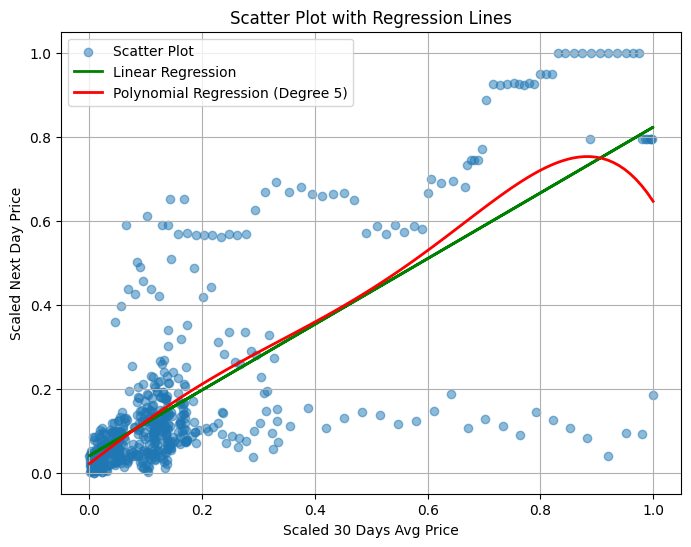

Correlation between ma Price and Price(원/kg): 0.7559322150253063


In [15]:
price_ma_price_scatter('RD_A_J',month = False, p = 5, window_size = 30)

In [17]:
def graph_trend_23(dataset_code, kind):

    # 주어진 데이터프레임 생성
    df = data_list[f'data_{dataset_code}']

    # timestamp 열을 datetime 형식으로 변환
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # 2월과 3월에 해당하는 데이터만 선택
    mask = (df['timestamp'].dt.month == 2) | (df['timestamp'].dt.month == 3)
    filtered_df = df[mask]

    # 인덱스 초기화 및 새로운 index 순서대로 부여
    filtered_df = filtered_df.reset_index(drop=True)
    filtered_df['new_index'] = range(len(filtered_df))

    # 꺾은선 그래프 그리기
    plt.figure(figsize=(20, 6))
    if kind == 'both':
        plt.plot(filtered_df['new_index'], filtered_df['supply(kg)'], linestyle='-', color='b')
        plt.plot(filtered_df['new_index'], filtered_df['price(원/kg)'], linestyle='-', color='r')
        plt.title('supply(kg)_price(원/kg) over Time in February and March')
        plt.xlabel('Date')
        plt.ylabel('supply(kg)_price(원/kg)')
        plt.ylim(0, 40000)

    elif kind == 'supply':
        plt.plot(filtered_df['new_index'], filtered_df['supply(kg)'], linestyle='-', color='b')
        plt.title('supply(kg) over Time in February and March')
        plt.xlabel('Date')
        plt.ylabel('supply(kg)')
        plt.ylim(0, 40000)

    elif kind == 'price':
        plt.plot(filtered_df['new_index'], filtered_df['price(원/kg)'], linestyle='-', color='r')
        plt.title('price(원/kg) over Time in February and March')
        plt.xlabel('Date')
        plt.ylabel('price(원/kg)')

    custom_xticks = [27, 58, 87, 118, 146, 178, 206, 237]
    plt.xticks(custom_xticks)

    plt.legend()  # 범례 표시
    plt.grid(True)
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


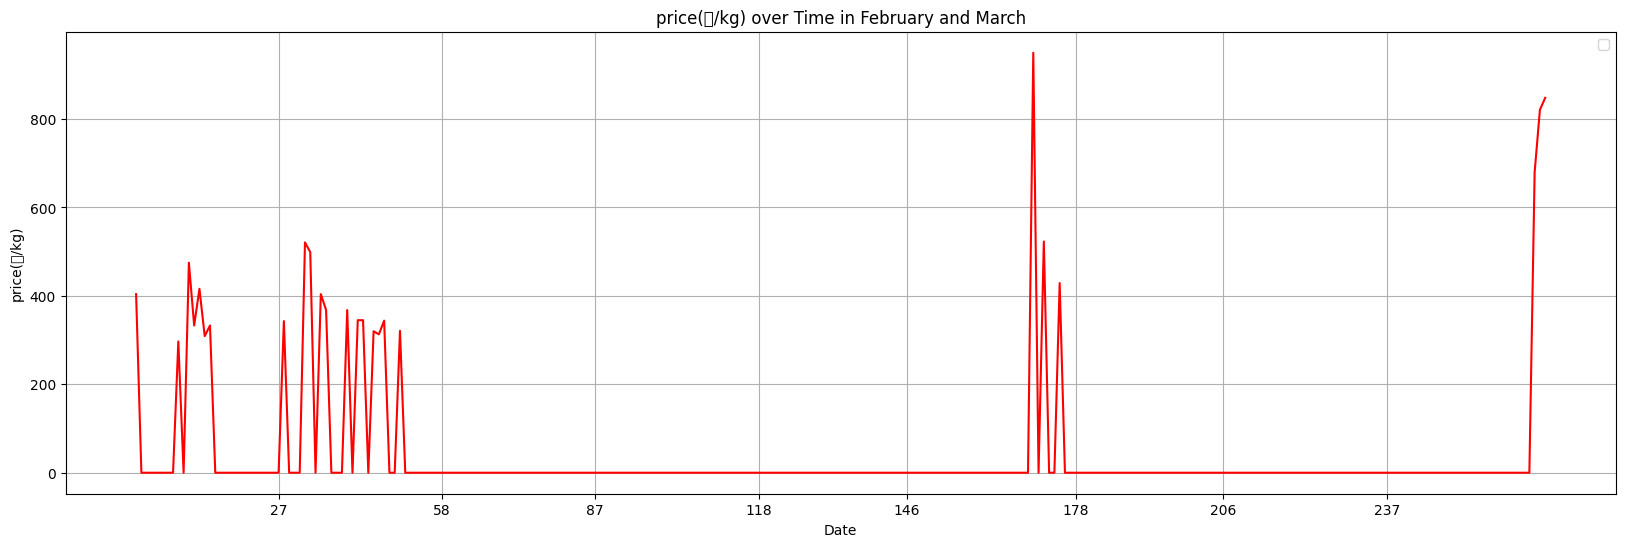

In [26]:
graph_trend_23('CB_A_S','price')